In [1]:
# Import libraries
import zipfile
import os
from pathlib import Path
import random
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import datetime
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout



In [2]:
# Replace 'your_file.zip'
with zipfile.ZipFile('drive/MyDrive/Rock-Paper-Scissors.zip', 'r') as zip_ref:
  zip_ref.extractall()  # Extract all files from the ZIP
  zip_ref.close()


In [3]:
# How many images in each folder?


# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("Rock-Paper-Scissors"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'Rock-Paper-Scissors'.
There are 3 directories and 0 images in 'Rock-Paper-Scissors/test'.
There are 0 directories and 124 images in 'Rock-Paper-Scissors/test/paper'.
There are 0 directories and 124 images in 'Rock-Paper-Scissors/test/scissors'.
There are 0 directories and 124 images in 'Rock-Paper-Scissors/test/rock'.
There are 3 directories and 0 images in 'Rock-Paper-Scissors/validation'.
There are 0 directories and 11 images in 'Rock-Paper-Scissors/validation/paper'.
There are 0 directories and 11 images in 'Rock-Paper-Scissors/validation/scissors'.
There are 0 directories and 11 images in 'Rock-Paper-Scissors/validation/rock'.
There are 3 directories and 0 images in 'Rock-Paper-Scissors/train'.
There are 0 directories and 840 images in 'Rock-Paper-Scissors/train/paper'.
There are 0 directories and 840 images in 'Rock-Paper-Scissors/train/scissors'.
There are 0 directories and 840 images in 'Rock-Paper-Scissors/train/rock'.


In [4]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32

train_dir = "Rock-Paper-Scissors/train/"
test_dir = "Rock-Paper-Scissors/test/"

train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                                   batch_size=BATCH_SIZE,
                                                                   class_mode='categorical',
                                                                   shuffle=True)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(IMG_HEIGHT,IMG_WIDTH),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               shuffle=True)

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=(IMG_HEIGHT,IMG_WIDTH),
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical'
                                            )



Augmented training images:
Found 2520 images belonging to 3 classes.
Training images:
Found 2520 images belonging to 3 classes.
Testing images:
Found 372 images belonging to 3 classes.
Validation images:
Found 33 images belonging to 3 classes.


In [ ]:
train_data_augmented.class_indices




{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
train_data.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
test_data.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
validation_data.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [5]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)

data_dir = pathlib.Path("Rock-Paper-Scissors/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['paper' 'rock' 'scissors']


In [ ]:
images, labels = train_data[0]  # Get the first batch of data
augmented_images, augmented_labels = train_data_augmented[0]  # Get the first batch of augmented data

In [ ]:
# Show original image and augmented image
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
vgg_url = "https://tfhub.dev/google/imagenet/vgg16/feature_vector/4"

# Load the VGG16 model without the top (fully connected) layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))



In [ ]:
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=vgg_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False





In [ ]:
class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-8, max_lr=2, momentum=0.9, logscale=True, num_iterations=100):
        super(LearningRateFinder, self).__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.momentum = momentum
        self.logscale = logscale
        self.num_iterations = num_iterations

    def on_train_begin(self, logs=None):
        self.learning_rates = []
        self.losses = []
        self.best_loss = np.inf
        self.avg_loss = 0
        self.batch_num = 0
        self.beta = 0.98

    def on_batch_end(self, batch, logs=None):
        lr = self.get_lr()
        self.batch_num += 1
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * logs['loss']
        smoothed_loss = self.avg_loss / (1 - self.beta**self.batch_num)

        self.learning_rates.append(lr)
        self.losses.append(smoothed_loss)

        if smoothed_loss < self.best_loss or self.batch_num==1:
            self.best_loss = smoothed_loss
        if smoothed_loss > 4 * self.best_loss or lr > self.max_lr:
            self.model.stop_training = True

    def get_lr(self):
        if self.logscale:
            return self.min_lr * (self.max_lr/self.min_lr)**(self.batch_num/self.num_iterations)
        return self.min_lr + (self.max_lr-self.min_lr)*(self.batch_num/self.num_iterations)

    def plot_lr(self):
        plt.plot(self.learning_rates, self.losses)
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [ ]:
# model = create_model(efficientnet_url,num_classes=train_data.num_classes)

lr_finder = LearningRateFinder(min_lr=1e-8, max_lr=2, num_iterations=100)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# steps_per_epoch = len(train_data) + len(train_data_augmented) #this is mandatory, otherwise it will keep looping


**For Learning Rate**

In [ ]:
history = model.fit(
    x=train_data_augmented,
    epochs=1,  # Run for only one epoch
    validation_data=test_data,
    callbacks=[lr_finder],
    verbose=0
)

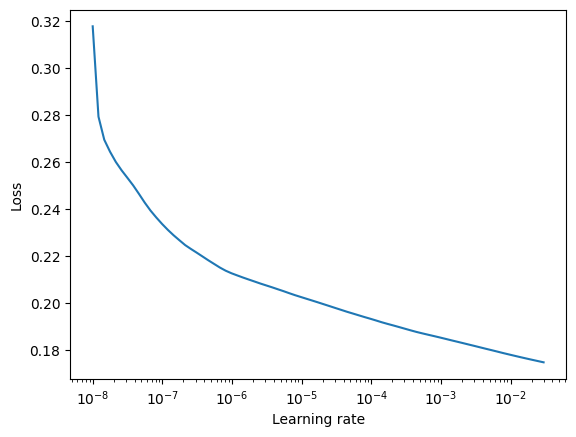

In [ ]:
lr_finder.plot_lr()

**For Model**

In [ ]:
history = model.fit(
        x=train_data_augmented,
        validation_data=test_data,
        batch_size=32,
        epochs=10,
        verbose=1
    )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 581ms/step - accuracy: 0.9924 - loss: 0.0361 - val_accuracy: 0.9785 - val_loss: 0.0595
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 576ms/step - accuracy: 0.9936 - loss: 0.0258 - val_accuracy: 1.0000 - val_loss: 0.0325
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 571ms/step - accuracy: 0.9947 - loss: 0.0243 - val_accuracy: 0.9946 - val_loss: 0.0388
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 81s 576ms/step - accuracy: 0.9894 - loss: 0.0313 - val_accuracy: 0.9731 - val_loss: 0.0716
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 579ms/step - accuracy: 0.9970 - loss: 0.0166 - val_accuracy: 1.0000 - val_loss: 0.0216
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 83s 577ms/step - accuracy: 0.9893 - loss: 0.0292 - val_accuracy: 0.9731 - val_loss: 0.0482
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 81s 571ms/step - accuracy: 0.9917 - loss: 0.0259 - val_accuracy: 0.9651 - val_loss: 0.1134
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 583ms/step - accuracy: 0.9949 - loss: 0.0180 - val_accuracy: 0.975

In [ ]:
# Save a model
model.save("train1vgg_augmented_model.keras")

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

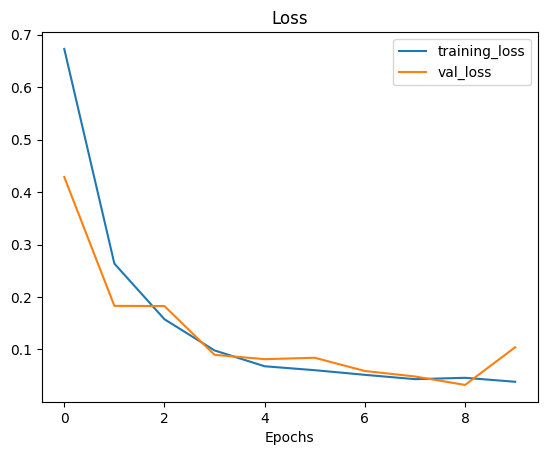

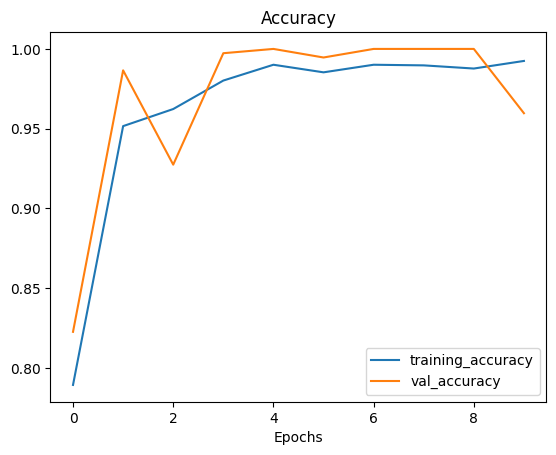

In [ ]:
# Check out the loss curves of model
plot_loss_curves(history)